# Notes

- [x] Add progress bar
- [x] Add auto arima
- [ ] Add auto skar
- [ ] Add baselines
- [ ] Add metrics
- [x] Add confidence intervals
- [ ] Add residuals
- [ ] Add simple validation metrics

# Setup

In [14]:
%load_ext autoreload
%autoreload 2

In [16]:
import sys
sys.path.append("..")

from dataclasses import dataclass, field
from typing import List, Optional, Union, Any
from typing_extensions import Protocol
from copy import deepcopy
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, widgets

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm

plt.rcParams["figure.figsize"] = (12, 4)

# Types

In [4]:
class ScikitModel(Protocol):
    def fit(self, X, y, sample_weight=None): ...
    def predict(self, X): ...
    def score(self, X, y, sample_weight=None): ...
    def set_params(self, **params): ...
    def get_params(self, deep=True): ...

# Data

In [7]:
stocks = pd.read_csv("../data/all_stocks_5yr.csv.gz", parse_dates=["date"])
stocks

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [8]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


In [9]:
stocks = stocks.set_index("date").groupby("Name").resample("W").mean().reset_index()
stocks

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070000,45.350000,45.000000,45.080000,1824755.00
1,A,2013-02-17,44.598000,44.878000,44.040000,44.160000,5165006.80
2,A,2013-02-24,42.255000,42.545000,41.871250,42.170000,3689833.75
3,A,2013-03-03,41.332000,41.891000,40.898000,41.480000,3985236.20
4,A,2013-03-10,42.780000,43.178000,42.518000,42.842000,2878377.80
...,...,...,...,...,...,...,...
128835,ZTS,2018-01-14,74.334000,75.013000,73.879140,74.648000,2431182.00
128836,ZTS,2018-01-21,76.302500,76.747500,75.667500,76.315000,3196819.50
128837,ZTS,2018-01-28,78.018000,78.784000,77.783000,78.548000,2780926.20
128838,ZTS,2018-02-04,78.222000,78.760000,77.396000,77.772000,3236979.20


# Sandbox

In [10]:
import darts.models
import darts.metrics
from darts.timeseries import TimeSeries
from warnings import filterwarnings
filterwarnings('ignore')

In [17]:
#data = stocks[stocks.Name.isin(["A", "AAL"])]
data = stocks[stocks.Name.isin(["A"])]

In [18]:
data

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070,45.350000,45.00000,45.080000,1.824755e+06
1,A,2013-02-17,44.598,44.878000,44.04000,44.160000,5.165007e+06
2,A,2013-02-24,42.255,42.545000,41.87125,42.170000,3.689834e+06
3,A,2013-03-03,41.332,41.891000,40.89800,41.480000,3.985236e+06
4,A,2013-03-10,42.780,43.178000,42.51800,42.842000,2.878378e+06
...,...,...,...,...,...,...,...
257,A,2018-01-14,70.702,71.430000,70.12500,71.028000,2.039419e+06
258,A,2018-01-21,72.105,72.623750,71.59500,72.137500,1.905580e+06
259,A,2018-01-28,73.870,74.161000,73.22800,73.836000,1.796494e+06
260,A,2018-02-04,73.548,74.002000,72.84000,73.006000,1.827100e+06


In [183]:
from tstools.forecast.univariate import Univariate
from tstools.forecast.univariate import Naive
from tstools.forecast.univariate import AutoARIMA

In [25]:
model = Naive(time_col="date", target_col="close", regressor_cols=None, freq="W")

In [26]:
model.fit(data)

Naive(time_col='date', target_col='close', regressor_cols=None, freq='W')

In [28]:
future = model.get_future_dataframe(data, fh=10)

In [30]:
y_fcst = model.predict(future)

<AxesSubplot:xlabel='date'>

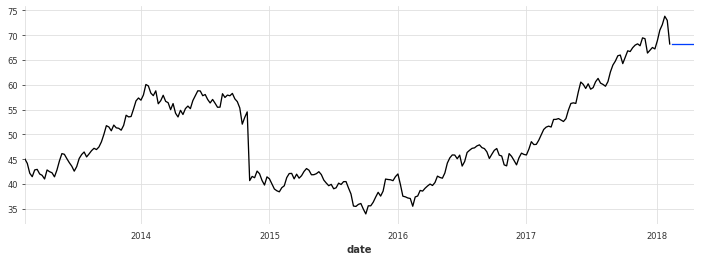

In [41]:
data.set_index("date")["close"].plot()
y_fcst.set_index("date")["y_fcst"].plot()

In [42]:
y_hfcst = model.historical_forecasts(data, fh=10)

100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 2925.92it/s]


In [46]:
y_hfcst[0]

,date,y_fcst
0,2015-08-16,40.49
1,2015-08-23,40.49
2,2015-08-30,40.49
3,2015-09-06,40.49
4,2015-09-13,40.49
5,2015-09-20,40.49
6,2015-09-27,40.49
7,2015-10-04,40.49
8,2015-10-11,40.49
9,2015-10-18,40.49


<AxesSubplot:xlabel='date'>

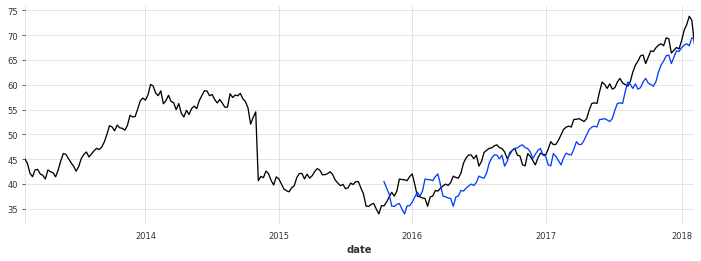

In [52]:
data.set_index("date")["close"].plot()
pd.concat([y_fcst.tail(1) for y_fcst in y_hfcst]).set_index("date")["y_fcst"].plot()

In [55]:
import pmdarima as pm

In [58]:
y = data.set_index("date")["open"]

In [74]:
arima = pm.AutoARIMA()

In [75]:
arima.fit(y)

AutoARIMA()

In [61]:
y_pred = arima.predict()

In [62]:
y_pred

array([68.67, 68.67, 68.67, 68.67, 68.67, 68.67, 68.67, 68.67, 68.67,
       68.67])

In [66]:
model = Univariate(time_col="date", target_col="close", regressor_cols=None, freq="W")

In [68]:
future = model.get_future_dataframe(data, fh=10)

In [70]:
future["y_fcst"] = y_pred

In [71]:
future

,date,y_fcst
0,2018-02-18,68.67
1,2018-02-25,68.67
2,2018-03-04,68.67
3,2018-03-11,68.67
4,2018-03-18,68.67
5,2018-03-25,68.67
6,2018-04-01,68.67
7,2018-04-08,68.67
8,2018-04-15,68.67
9,2018-04-22,68.67


In [191]:
data

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070,45.350000,45.00000,45.080000,1.824755e+06
1,A,2013-02-17,44.598,44.878000,44.04000,44.160000,5.165007e+06
2,A,2013-02-24,42.255,42.545000,41.87125,42.170000,3.689834e+06
3,A,2013-03-03,41.332,41.891000,40.89800,41.480000,3.985236e+06
4,A,2013-03-10,42.780,43.178000,42.51800,42.842000,2.878378e+06
...,...,...,...,...,...,...,...
257,A,2018-01-14,70.702,71.430000,70.12500,71.028000,2.039419e+06
258,A,2018-01-21,72.105,72.623750,71.59500,72.137500,1.905580e+06
259,A,2018-01-28,73.870,74.161000,73.22800,73.836000,1.796494e+06
260,A,2018-02-04,73.548,74.002000,72.84000,73.006000,1.827100e+06


In [192]:
model = AutoARIMA(time_col="date", target_col="close", regressor_cols=None, freq="W")

In [193]:
model.fit(data)

AutoARIMA(time_col='date', target_col='close', regressor_cols=None, freq='W', arima_params={}, fit_params={})

In [198]:
fcst = model.predict(model.get_future_dataframe(data, fh=10), conf_int=0.95)

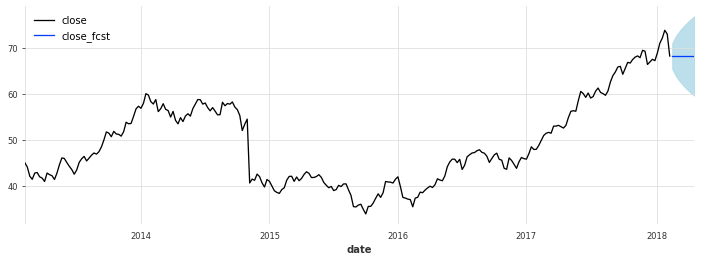

In [199]:
model.plot_fcst(fcst)

In [200]:
hfcst = model.historical_forecasts(data, fh=10)

100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [00:50<00:00,  2.39it/s]


In [207]:
hfcst[1]

,date,close_fcst
0,2015-08-23,39.198
1,2015-08-30,39.198
2,2015-09-06,39.198
3,2015-09-13,39.198
4,2015-09-20,39.198
5,2015-09-27,39.198
6,2015-10-04,39.198
7,2015-10-11,39.198
8,2015-10-18,39.198
9,2015-10-25,39.198


In [182]:
hfcst_ex = [fcst.merge(data[[self.time_col, self.target_col]], on="date") for fcst in hfcst]

[        date  close_fcst
 0 2015-08-16       40.49
 1 2015-08-23       40.49
 2 2015-08-30       40.49
 3 2015-09-06       40.49
 4 2015-09-13       40.49
 5 2015-09-20       40.49
 6 2015-09-27       40.49
 7 2015-10-04       40.49
 8 2015-10-11       40.49
 9 2015-10-18       40.49,
         date  close_fcst
 0 2015-08-23      39.198
 1 2015-08-30      39.198
 2 2015-09-06      39.198
 3 2015-09-13      39.198
 4 2015-09-20      39.198
 5 2015-09-27      39.198
 6 2015-10-04      39.198
 7 2015-10-11      39.198
 8 2015-10-18      39.198
 9 2015-10-25      39.198,
         date  close_fcst
 0 2015-08-30      37.996
 1 2015-09-06      37.996
 2 2015-09-13      37.996
 3 2015-09-20      37.996
 4 2015-09-27      37.996
 5 2015-10-04      37.996
 6 2015-10-11      37.996
 7 2015-10-18      37.996
 8 2015-10-25      37.996
 9 2015-11-01      37.996,
         date  close_fcst
 0 2015-09-06      35.562
 1 2015-09-13      35.562
 2 2015-09-20      35.562
 3 2015-09-27      35.562
 4 2015-1

In [181]:
model.error_table(data, hfcst).mean(axis=0)

0     -4.458150
1     -3.452950
2     -2.313350
3      0.397250
4      0.687650
         ...   
117    0.295550
118    0.418100
119    1.399100
120    0.157700
121    0.227633
Length: 122, dtype: float64

In [208]:
hfcst_last = pd.concat([fcst.tail(1) for fcst in hfcst])

In [209]:
hfcst_last

,date,close_fcst
9,2015-10-18,40.490
9,2015-10-25,39.198
9,2015-11-01,37.996
9,2015-11-08,35.562
9,2015-11-15,35.480
...,...,...
9,2018-01-14,68.008
9,2018-01-21,68.272
9,2018-01-28,67.886
9,2018-02-04,69.480


<AxesSubplot:xlabel='date'>

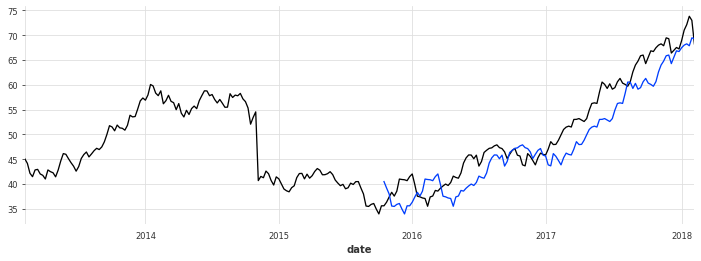

In [210]:
data.set_index("date")["close"].plot()
hfcst_last.set_index("date")["close_fcst"].plot()

In [152]:
err_table = pd.concat([fcst["close_fcst"] for fcst in hfcst], axis=1)

In [154]:
err_table.shape

(10, 122)

In [156]:
err_table.columns = np.arange(0, err_table.shape[1])

In [157]:
err_table

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,40.654550,39.380684,38.191348,35.776982,35.691165,36.097484,36.272096,35.141544,34.173410,35.798489,...,64.115793,65.420299,66.706295,66.566182,67.351733,67.841990,68.130160,67.792899,69.394457,69.155111
1,40.814539,39.558532,38.381784,35.987104,35.897635,36.297872,36.467719,35.340817,34.372804,35.988828,...,63.951592,65.260387,66.552164,66.413916,67.188770,67.743370,67.974680,67.742599,69.248691,69.010618
2,40.970092,39.731671,38.567431,36.192474,36.099514,36.493766,36.658969,35.535909,34.568264,36.175106,...,63.789373,65.102245,66.399591,66.263185,67.027497,67.686489,67.820700,67.584842,69.104192,68.867386
3,41.121333,39.900228,38.748409,36.393200,36.296906,36.685267,36.845944,35.726908,34.759865,36.357408,...,63.629112,64.945853,66.248561,66.113974,66.867895,67.569613,67.668208,67.391888,68.960948,68.725403
4,41.268381,40.064322,38.924836,36.589387,36.489909,36.872473,37.028740,35.913899,34.947685,36.535821,...,63.470785,64.791192,66.099057,65.966268,66.709948,67.407146,67.517187,67.172642,68.818948,68.584658
5,41.411352,40.224072,39.096827,36.781138,36.678621,37.055481,37.207450,36.096968,35.131798,36.710426,...,63.314369,64.638242,65.951065,65.820051,66.553638,67.210354,67.367625,66.934074,68.678182,68.445140
6,41.550360,40.379594,39.264492,36.968553,36.863138,37.234386,37.382164,36.276196,35.312277,36.881305,...,63.159842,64.486985,65.804569,65.675309,66.398948,66.988044,67.219506,66.681640,68.538639,68.306839
7,41.685514,40.530998,39.427941,37.151731,37.043552,37.409278,37.552974,36.451663,35.489194,37.048538,...,63.007179,64.337402,65.659554,65.532027,66.245862,66.747091,67.072817,66.419602,68.400308,68.169744
8,41.816922,40.678394,39.587280,37.330766,37.219956,37.580249,37.719965,36.623449,35.662619,37.212203,...,62.856359,64.189475,65.516004,65.390190,66.094362,66.492862,66.927544,66.151285,68.263179,68.033845
9,41.944686,40.821889,39.742612,37.505753,37.392437,37.747386,37.883224,36.791630,35.832621,37.372375,...,62.707359,64.043184,65.373906,65.249783,65.944433,66.229537,66.783674,65.879277,68.127241,67.899130


In [161]:
fcst = hfcst[0]

In [164]:
fcst.merge(data[["date", "close"]], on="date")

,date,close_fcst,close
0,2015-08-16,40.654550,39.1980
1,2015-08-23,40.814539,37.9960
2,2015-08-30,40.970092,35.5620
3,2015-09-06,41.121333,35.4800
4,2015-09-13,41.268381,35.8925
5,2015-09-20,41.411352,36.0720
6,2015-09-27,41.550360,34.9380
7,2015-10-04,41.685514,33.9700
8,2015-10-11,41.816922,35.6040
9,2015-10-18,41.944686,35.6060


In [166]:
af_hfcst = [fcst.merge(data[["date", "close"]], on="date") for fcst in hfcst]

In [170]:
pd.concat([fcst["close"] - fcst["close_fcst"] for fcst in af_hfcst], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,-1.456550,-1.384684,-2.629348,-0.296982,0.201335,-0.025484,-1.334096,-1.171544,1.430590,-0.192489,...,1.466207,1.441701,0.013705,0.915818,0.656267,0.430010,-0.244160,1.687101,-0.090457,-2.745111
1,-2.818539,-3.996532,-2.901784,-0.094604,0.174365,-1.359872,-2.497719,0.263183,1.233196,0.341172,...,2.910408,1.459613,0.929836,1.594084,1.083230,0.142630,1.505320,1.561401,-2.838691,-2.038618
2,-5.408092,-4.251671,-2.674931,-0.120474,-1.161514,-2.523766,-1.054969,0.070091,1.761736,1.196894,...,2.930627,2.379755,1.608409,2.008815,0.858503,1.793511,1.483300,-1.174842,-2.132192,-1.331386
3,-5.641333,-4.007728,-2.676409,-1.455200,-2.326906,-1.081267,-1.239944,0.603092,2.612135,1.970592,...,3.852888,3.062147,2.023439,1.772026,2.612105,1.734387,-1.258208,-0.419888,-1.424948,-1.482903
4,-5.375881,-3.992322,-3.986836,-2.619387,-0.885909,-1.266473,-0.698740,1.458101,3.380315,1.028179,...,4.537215,3.480808,1.786943,3.513732,2.594052,-0.997146,-0.545187,0.363358,-1.576448,0.320342
5,-5.339352,-5.286072,-5.126827,-1.177138,-1.072621,-0.725481,0.164550,2.231032,2.432202,1.855574,...,4.957631,3.247758,3.528935,3.483949,-0.143638,-0.238354,0.168375,0.308426,0.226818,2.582860
6,-6.612360,-6.409594,-3.660492,-1.362553,-0.533138,0.137614,0.945836,1.287804,3.253723,4.121195,...,4.726158,4.993015,3.499431,0.734691,0.573052,0.547956,0.022994,2.223360,2.489361,3.830661
7,-7.715514,-4.926998,-3.821941,-0.821731,0.328448,0.918722,0.011026,2.114337,5.513306,3.861462,...,6.472821,4.966598,0.750446,1.439973,1.290138,0.495409,1.832183,4.608398,3.737192,5.666256
8,-6.212922,-5.072394,-3.257280,0.041234,1.108044,-0.016249,0.846035,4.379051,5.247381,3.645797,...,6.447641,2.220525,1.455996,2.145810,1.148138,2.412138,4.100456,5.986215,5.572821,4.972155
9,-6.338686,-4.491889,-2.370612,0.822247,0.171563,0.818614,3.119276,4.118370,5.025379,3.301625,...,3.702641,2.928816,2.162094,1.992717,2.960567,4.798463,5.353826,7.956723,4.878759,0.344203
